---
# Homework 7
---

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd           # for reading file
from scipy.stats import rankdata
import pandas_profiling as pp # statistical visualise
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import seaborn as sns


from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.ensemble import ExtraTreesClassifier


from pylab import rcParams
# rcParams['figure.figsize'] = 20, 20
%matplotlib inline

from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [3]:
train_df = pd.read_csv('../data/train.csv', index_col='Unnamed: 0', sep='\t')
test_df = pd.read_csv('../data/test.csv', index_col='Unnamed: 0', sep='\t')

print ("rows \t\t: ", train_df.shape[0])
print ("columns \t: ", train_df.shape[1])
# train_df.head(1) , test_df.head(1)

rows 		:  30500
columns 	:  346


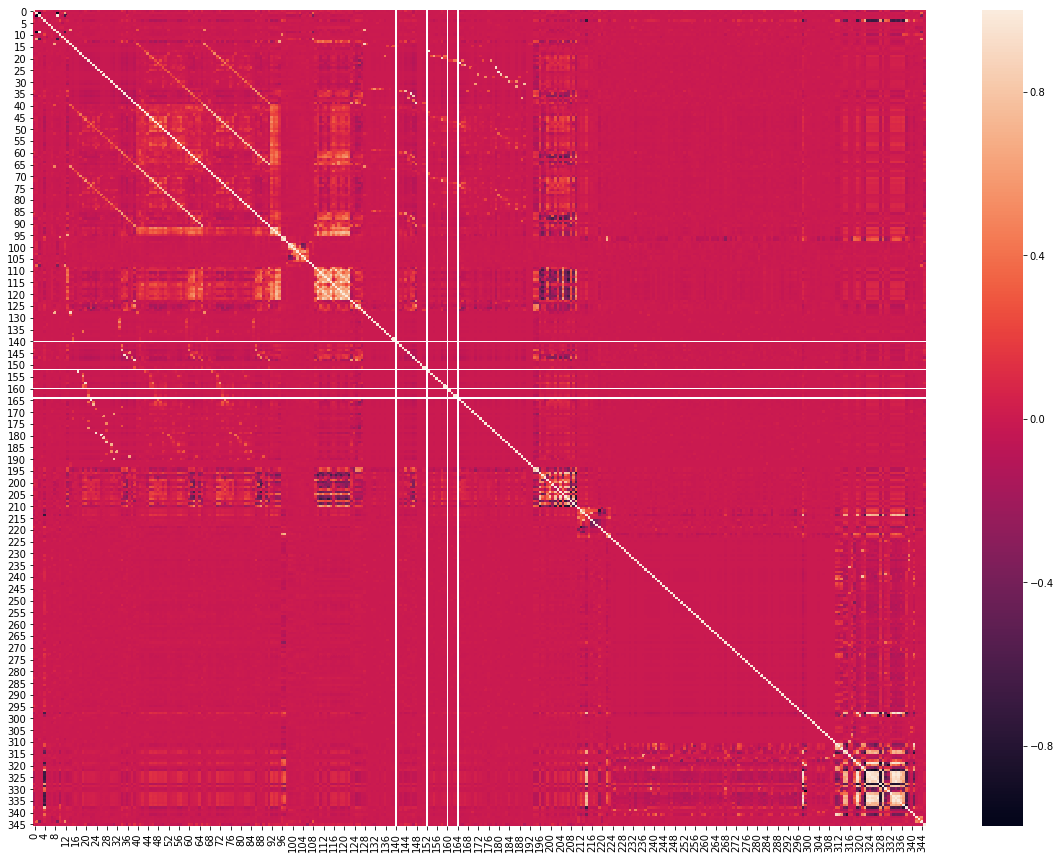

In [4]:
plt.subplots(figsize=(20,15))
sns.heatmap(train_df.corr());

In [5]:
def one_hot_encoding(train, test):
    for i in train:
        if len(train[i].unique()) < 15 and len(train[i].unique()) > 1:
            train = pd.concat([train, pd.get_dummies(train[i], prefix=i)], axis=1)
            train.drop(i, axis=1, inplace=True)
            
            test = pd.concat([test, pd.get_dummies(test[i], prefix=i)], axis=1)
            test.drop(i, axis=1, inplace=True)
    return train, test

def    clean_data(train, test, delete):
    columns_name = []

    for i in test:
#       Выбирает колонки у которых константа в обоих таблицах
        if (len(train[i].unique()) == 1):
            columns_name.append(i)
#       Выбирает значения у которих значение константа в одной из таблиц
        elif (len(train[i].unique()) == 2) and (len(test[i].unique()) < 2):
            columns_name.append(i)
#       убирает 
        elif delete\
                and len(train[i].unique()) == 2\
                and min(train[i].value_counts()) / sum(train[i].value_counts()) * 100 < .05:
            columns_name.append(i)
    return columns_name

def get_corr_cols(df, method):
    corr_matrix = df.corr(method=method).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(upper[column] > 0.995)]

#### Разбиваем выборку

In [6]:
X_train = train_df.drop(['0'], axis=1)
y_train = train_df['0']

X_test = test_df.drop(['0'], axis=1)
y_test = test_df['0']

#### Удаляем признаки у которых только 1 уникальное значения, и у которых вариабельность меньше 0.5%

In [7]:
clean_columns = clean_data(X_train, X_test, 0)
X_train.drop(clean_columns, axis=1, inplace=True)
X_test.drop(clean_columns, axis=1, inplace=True)

#### Кодируем категориальные признаки one_hot_encoding

In [8]:
# X_train, X_test = one_hot_encoding(X_train, X_validation);
# X_train.drop(list(set(X_train.columns) ^ set(X_test.columns)), axis=1, inplace=True)

#### Удаляем признаки у которых уровень корреляция больше 99

In [9]:
corr_arr = get_corr_cols(X_train, 'pearson')
X_train.drop(corr_arr, axis=1, inplace=True)
X_test.drop(corr_arr, axis=1, inplace=True)

In [10]:
print ("Train : ")
print ("\t", X_train.shape)

Train : 
	 (30500, 318)


#### Для быстроты обработки - удаляем данные вклад которых в можель не такой большой (перед сабмитом закомментить)

(-1, 79)

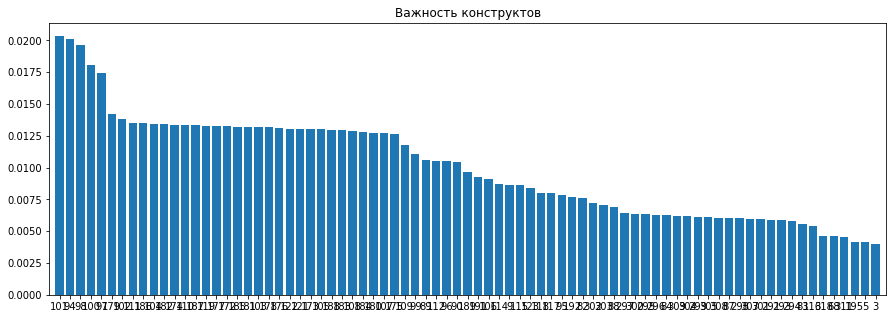

In [11]:
forest = RandomForestRegressor(n_estimators=500, max_features=10,
                                random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = int(len(X_train.columns) / 4)
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

plt.figure(figsize=(15, 5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])

In [12]:
important_values = zip(X_train.columns, forest.feature_importances_)

to_del = []
for i , j in important_values:
    if j < 0.001:
        to_del.append(i)

X_train.drop(to_del, axis=1, inplace=True)
X_test.drop(to_del, axis=1, inplace=True)

#### Разбиваем на train и test

In [13]:
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, 
                                                   y_train,
                                                   test_size=0.10, 
                                                   random_state=42,
                                                   stratify=y_train)

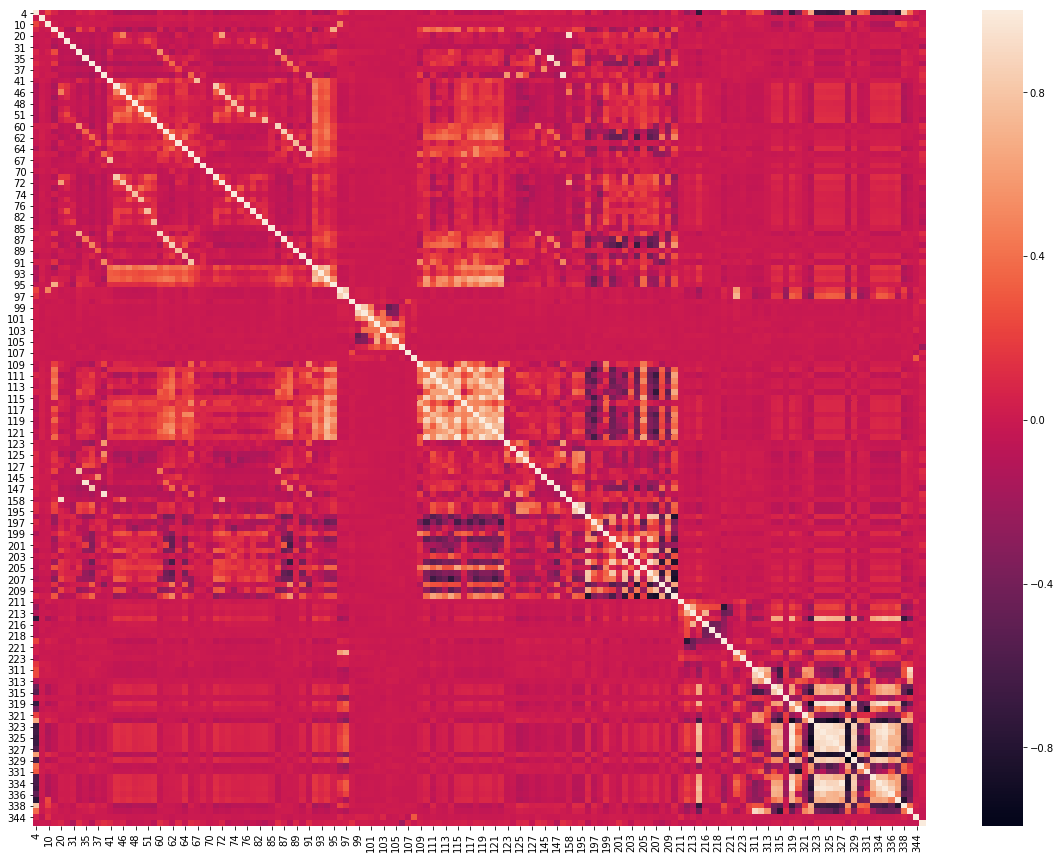

In [14]:
plt.subplots(figsize=(20,15))
sns.heatmap(X_train.corr());

---

Соревнование:   
https://boosters.pro/champ_modulbank_msk   
Форма с вопросами:    
https://docs.google.com/forms/d/e/1FAIpQLSdnACZoabDqSznt1rvci8eoQ5Bd3k-jUsDjmLQSDgM73RV-Fg/viewform

---

#### 1. Есть функция, которая аппроксимируется с помощью градиентного бустинга с lr = 0.01 и к-ом раундов 100. Что произойдет, если выкинуть первую модель из бустинга (не константу, а нормальное дерево)? *

Исходя из того, что последующие модели строятся на остатка предидущей, могу предположить что ни к чему хорошему это не приведет.

---

#### 2. В конце статьи https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db есть картинка с результатами сравнения трех алгоритмов. Можно ли считать результаты сравнения точности объективными? Дайте развернутый ответ.

Я думаю что сравнение результатов 3-х библиотек - неадекватное. тк идет сравнение исключительно на одних данных, а так же разные параметры у каждого классификатора.

---

### 3. Постройте XGBoost. Укажите значение на валидации и публичном лидерборде *

In [14]:
# !pip install hyperopt

In [15]:
import xgboost as xgb
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

ModuleNotFoundError: No module named 'hyperopt'

In [16]:
# Разбиваем нашу выборку
skf = StratifiedKFold(n_splits=10,
                      shuffle=True,
                      random_state=42)
# Преобразуем наши данные в нормальный для xgboost вид
xgb_train = xgb.DMatrix(X_train_1, label=y_train_1, feature_names=X_train_1.columns)
xgb_test = xgb.DMatrix(X_test_1, y_test_1, feature_names=X_test_1.columns)

In [17]:
# GridSearchCV for xgboost

rscv_param = {
#     'n_estimators' : 30,
    'max_depth': [5]
#     'colsample_bytree':
#     'subsample':
#     'gamma'
#     'alpha'
#     'lambda'
}

xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(estimator=xgb_model,
                        param_grid=rscv_param,
                        verbose=1)

xgb_grid.fit(X_train_1, y_train_1)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
allDone();

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   45.3s finished


0.11914164309717294
{'max_depth': 5}


In [17]:
param = {
    #default
    'objective': 'reg:logistic',
    'eta': 0.001, #reduced to get higher score
    'silent': 1,
    "nthread": 4,
    "random_seed": 1,
    "eval_metric": 'auc',
    
    # regularization parameters
    'gamma' : 3,
    'max_depth': 5,
    'max_leaves': 32,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    
    #lightgbm approach
    'tree_method': 'hist',
    'grow_policy': 'lossguide'
}
num_rounds = 10000

Best Cycle :  9279
Best Score :  0.7377530000000001


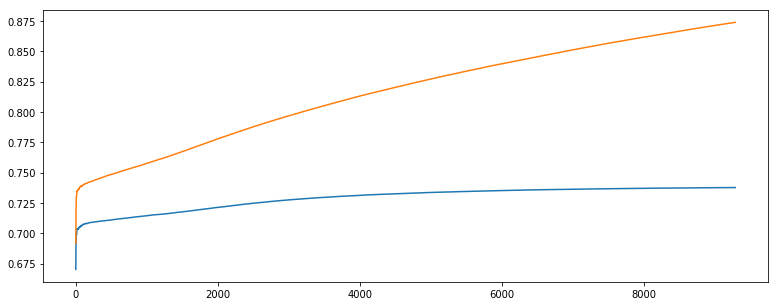

In [19]:
# Подбираем количество циклов
xgbResults = xgb.cv(params=param,
                    dtrain=xgb_train,
                    num_boost_round=num_rounds,
                    early_stopping_rounds=50,
                    folds=skf,
                    verbose_eval=False)

# Строим график по количествам циклов и скору
plt.subplots(figsize=(13,5))
plt.plot(range(xgbResults.shape[0]), xgbResults['test-auc-mean'])
plt.plot(range(xgbResults.shape[0]), xgbResults['train-auc-mean']);

# Запоминаем лучший цикл
best_num_cycle = np.argmax(xgbResults['test-auc-mean'])
max_score = np.max(xgbResults['test-auc-mean'])

print("Best Cycle : ", best_num_cycle)
print("Best Score : ", max_score)
allDone();

    Без подбора количества циклов обучения (num_boost_round):   
        0.7077061889039942
    С подбором количества циклов обучения (num_boost_round):   
        0.7312467263428615

In [18]:
# Создаем и тренируем классификатор на наших рапаметах и с лучшим значением цикла
# *тренируем на всей выборке
best_num_cycle = 9279
bestXgb = xgb.train(params=param,
                    dtrain=xgb_train,
                    num_boost_round=best_num_cycle)
allDone();

##### Local Score:

In [20]:
xgbpred = bestXgb.predict(xgb_test)
roc_auc_score(y_test_1, xgbpred)

0.7372673128645162

In [ ]:
# Создаем класификатор
xgboost_finish = xgb.XGBClassifier(**param)
# Тренируем на всех данных
xgboost_finish.fit(X_train, y_train);

In [ ]:
# Предсказываем и записываем в файл
pred = xgboost_finish.predict_proba(X_test)
solution = pd.DataFrame(pred[:,1])
solution.to_csv('xgboost_finish.csv')

    Rank site  : 0.74329474
    Rank local : 0.72770455

---

### 4. Постройте LightGBM. Укажите значение на валидации и публичном лидерборде *#### 

In [24]:
# !pip install lightgbm

In [25]:
# К сожалению возникли проблемы с установкой.

---

### 5. Постройте CatBoost. Укажите значение на валидации и публичном лидерборде *

In [51]:
# !pip install PY3

In [21]:
import catboost as ctb

In [ ]:
# Разбиваем нашу выборку
skf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=42)
# Преобразуем наши данные в нормальный для catboost вид
ctb_train = ctb.Pool(X_train_1, y_train_1)
ctb_test = ctb.Pool(X_test_1, y_test_1)

In [23]:
parameters = {
    #default
    'loss_function':'Logloss',
    'eval_metric': 'AUC',
    'iterations': 759,
    'learning_rate': 0.03,
    'random_seed': 42,
    'use_best_model': False,
    
    #regularization
    'rsm': 0.8,
    'l2_leaf_reg': 2
}


Iteration with suspicious time 43.4 sec ignored in overall statistics.
Best Cycle :  747
Best Score :  0.738840743607196


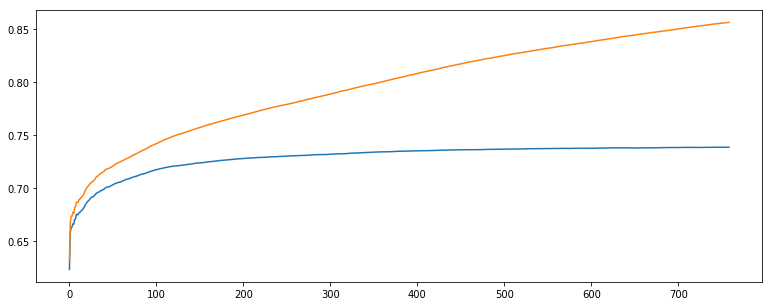

In [41]:
# Подбираем количество циклов
ctbResults = ctb.cv(pool=ctb_train,
                    params=parameters,
                    stratified=True,
                    seed=42,
                    nfold=skf,
                    logging_level='Silent')

# # Строим график по количествам циклов и скору
plt.subplots(figsize=(13,5))
plt.plot(range(ctbResults.shape[0]), ctbResults['test-AUC-mean'])
plt.plot(range(ctbResults.shape[0]), ctbResults['train-AUC-mean']);

# Запоминаем лучший цикл
best_num_cycle = np.argmax(ctbResults['test-AUC-mean'])
max_score = np.max(ctbResults['test-AUC-mean'])

print("Best Cycle : ", best_num_cycle)
print("Best Score : ", max_score)
allDone();

In [ ]:
# Создаем и тренируем классификатор на наших рапаметах и с лучшим значением цикла
# *тренируем на всей выборке
best_num_cycle = 747
bestctb = ctb.train(pool=ctb_train,
                    params=parameters,
                    num_boost_round=best_num_cycle,
                    logging_level='Silent')
allDone();

##### Local Score:

In [ ]:
ctb_pred = bestctb.predict(ctb_test)
roc_auc_score(y_test_1, ctb_pred)

In [ ]:
# Создаем класификатор
ctb_finish = ctb.CatBoostClassifier(**parameters,
                                    logging_level='Silent')
# Тренируем на всех данных
ctb_finish.fit(X_train, y_train);

In [ ]:
# Предсказываем и записываем в файл
pred = ctb_finish.predict_proba(X_test)
solution = pd.DataFrame(pred[:,1])
solution.to_csv('catboost_finish.csv')

    Rank site  : 0.75158783
    Rank local : 0.73513538

---

### 6. Подберите лучший вариант простого ансамбля. Опишите его и укажите значение на валидации и публичном лидерборде *

In [23]:
# Разбиваем нашу выборку
skf = StratifiedKFold(n_splits=10,
                      shuffle=True,
                      random_state=42)

# Преобразуем наши данные в нормальный для xgboost и catboost вид
ctb_test = ctb.Pool(X_test, y_test)
xgb_test = xgb.DMatrix(X_test, y_test, feature_names=X_test_1.columns)

In [87]:
X_test.sh, y_test.shape

((4166, 144), (4166,))

In [80]:
result = []

weight = .1
best_score = 0.0
for i in np.arange(.05, 1, .05):
    score = roc_auc_score(y_test, i * ctb_pred[:, 1] + (1 - i) * xgb_pred[:, 1])
    if best_score < score:
        best_score = score
        weight = i   
    #     print(score)

IndexError: too many indices for array

In [ ]:
weight, best_score

In [ ]:
test_df['0'] = (weight * log_reg.predict_proba(X_validation)[:, 1] + (1 - weight) * gsv.predict_proba(X_validation)[:, 1])

solution = pd.DataFrame(test_df['0'])
solution.to_csv('simple_ensemble.csv')
test_df.head()

---

### 7. Сделайте стекинг. Опишите его и укажите значение на валидации и публичном лидерборде *

---

### 8. Укажите ваш ник, значение на lb и валидации, опишите коротко решение *

---

#### Линк на гитхаб (без 8 задания) *
